### Experiments

#### Import Libraries

In [1]:
from utils.data_utils import split_dataset, TimeSeriesDataset
from utils.evaluation_utils import plot_multistep_forecast, evaluate_on_test_data
from utils.training_utils import train
import pandas as pd 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/codespace/.python/current/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Import Data

In [2]:
ETTm2 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm2.csv")
training_df, val_df, test_df = split_dataset(ETTm2, remain_same = False)

#### Multivariate Case

#### Global Parameters

In [3]:
p_lag = 96
future_steps = round(48)
batch_size = 8
epochs = 8
learning_rate=1.e-4
decomp_kernel_size = 24
number_of_forecasts = 100
target_column = ['OT']
feature_columns = [i for i in training_df.columns]

#### ETTm2

#### RLinear

Random seed set as 42
Rlinear activated
Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 : 23.82920990638733
Current (running) training loss at iteration 10000 : 21.887240492248534
Current (running) training loss at iteration 15000 : 17.716369768587747
Current (running) training loss at iteration 20000 : 15.104328050768375
Current (running) training loss at iteration 25000 : 13.626732208909988
Current (running) training loss at iteration 30000 : 12.711219569166502

Epoch 0: 

Train metrics: -------
Running (training) loss is 11.905535057159751.
Training MAE is 0.9000442907494287.
Training MSE is 11.974706113844057.
Training MAPE is 64706481.161465235.

Val metrics: -------
Running (validation) loss is 6.548419548118041.
Validation MAE is 0.6781037903212487.
Validation MSE is 6.612771031970264.
Validation MAPE is 0.020626555900226873.
---------------------------
Current learning rate is : 5e-05
---------------------------
Cu

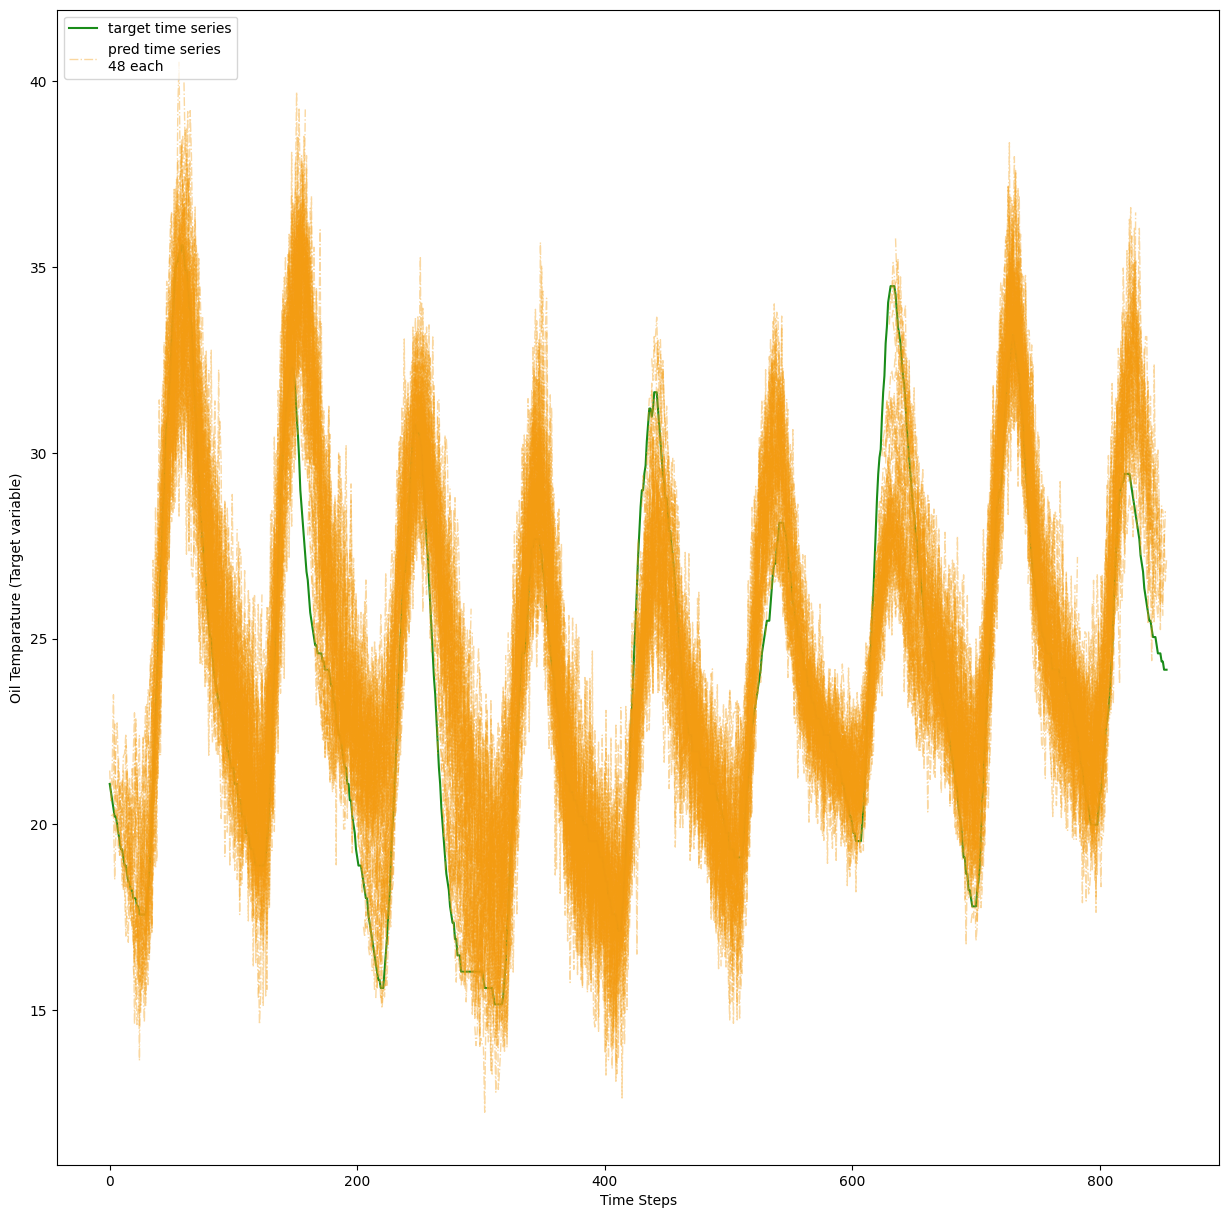

In [4]:
net, res = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            get_residuals = True, 
            model = 'rlinear'
            )

test_data = DataLoader(TimeSeriesDataset(test_df,future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)
#evaluate_on_test_data(test_data = test_data, neural_net = net)

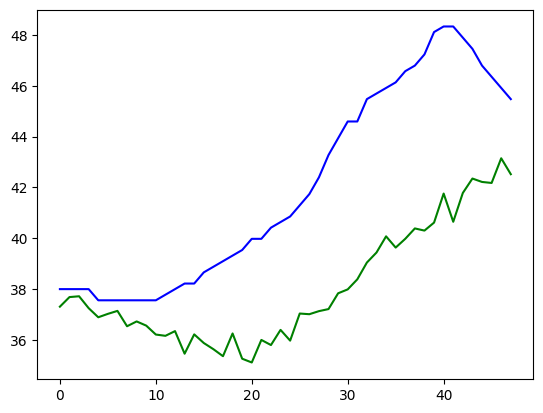

In [10]:
import matplotlib.pyplot as plt
neti = net.eval()
for i, (inputs, targets) in enumerate(test_data): 
    if i == 50: 
        break
    else: 
        output = neti(inputs)

plt.plot(output[1,:].tolist(), 'g')
plt.plot(targets[1,0,:].tolist(), 'b')

#### Dlinear

Random seed set as 42
Dlinear activated
Current learning rate is : 0.0001
---------------------------


Current (running) training loss at iteration 5000 : 18.58944076385498
Current (running) training loss at iteration 10000 : 15.547907088088989
Current (running) training loss at iteration 15000 : 13.119651695251465
Current (running) training loss at iteration 20000 : 11.746393889236451
Current (running) training loss at iteration 25000 : 10.811766997680664
Current (running) training loss at iteration 30000 : 10.833990987968445

Epoch 0: 

Train metrics: -------
Running (training) loss is 10.68548210215973.
Training MAE is 0.9053219849912467.
Training MSE is 10.752281820047125.
Training MAPE is 70418319.82729883.

Val metrics: -------
Running (validation) loss is 54.7116946087525.
Validation MAE is 2.1966348209443285.
Validation MSE is 54.78024066239084.
Validation MAPE is 0.06648468446848159.
---------------------------
Current learning rate is : 5e-05
---------------------------
Current (running) training loss at iteration 5000 : 8.481261365509033
Current (running) training loss at ite

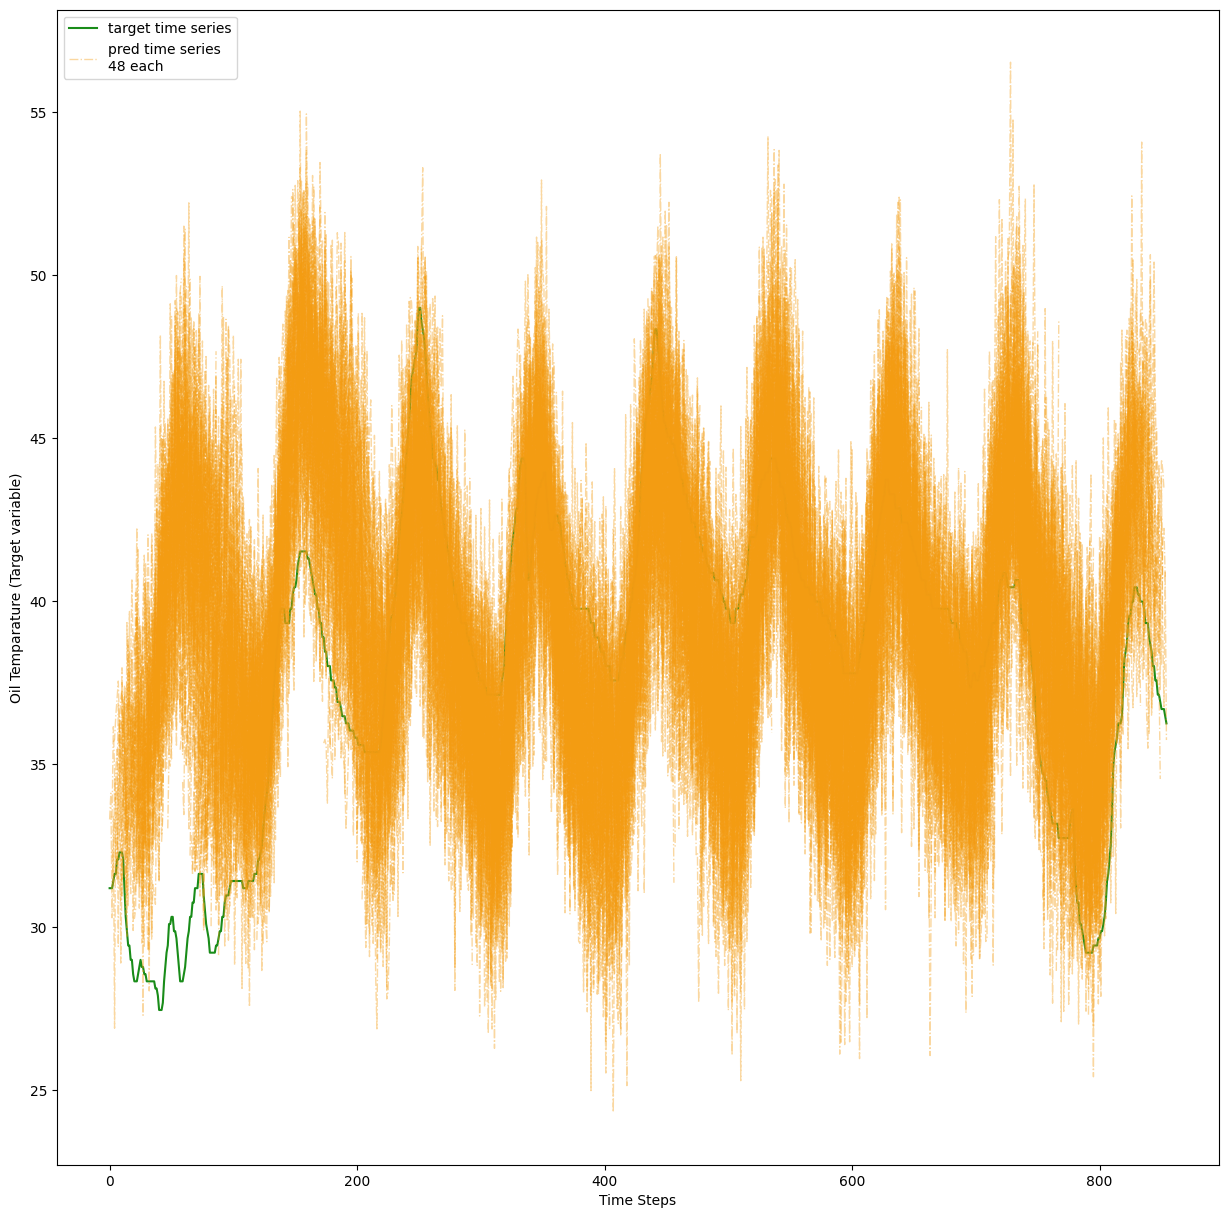

In [6]:
net, res = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            get_residuals = True, 
            model = 'dlinear'
            )

test_data = DataLoader(TimeSeriesDataset(test_df,future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)
evaluate_on_test_data(test_data = test_data, neural_net = net)

#### RLMP

Random seed set as 42
RMLP activated
Current learning rate is : 0.0001
---------------------------


Current (running) training loss at iteration 5000 : 34.15103763961792
Current (running) training loss at iteration 10000 : 26.215125174427033
Current (running) training loss at iteration 15000 : 20.059809621302286
Current (running) training loss at iteration 20000 : 16.20290729264021
Current (running) training loss at iteration 25000 : 14.707261218910217
Current (running) training loss at iteration 30000 : 13.692369370698929

Epoch 0: 

Train metrics: -------
Running (training) loss is 12.882676473059057.
Training MAE is 0.9050180617034954.
Training MSE is 12.951467582087405.
Training MAPE is 60587659.24700862.

Val metrics: -------
Running (validation) loss is 7.078883362597772.
Validation MAE is 0.7104712083536874.
Validation MSE is 7.143642597744215.
Validation MAPE is 0.021140445516283024.
---------------------------
Current learning rate is : 5e-05
---------------------------
Current (running) training loss at iteration 5000 : 3.695407676792145
Current (running) training loss at i

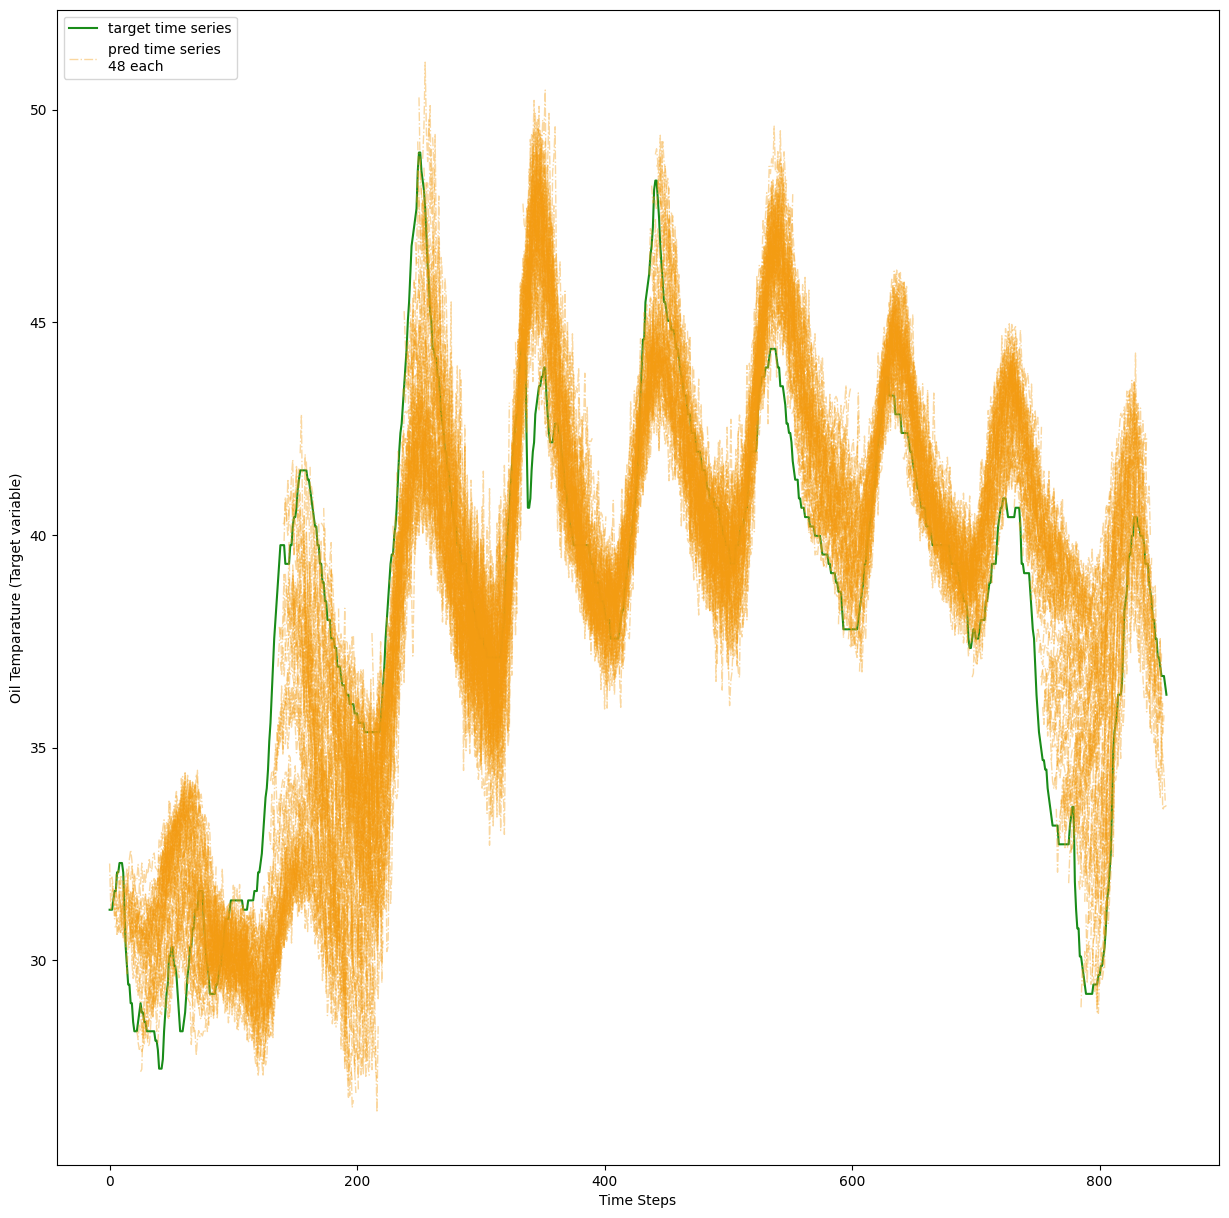

In [6]:
net, res = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            get_residuals = True, 
            model = 'rmlp'
            )

test_data = DataLoader(TimeSeriesDataset(test_df,future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)
evaluate_on_test_data(test_data = test_data, neural_net = net)